## Compare fits and covariance structure of 3 parameter fit and Gaussian Process (Gibbs kernel with 3 parameter fit function mean) on the 13 TeV data set and on a smooth data set. Smooth data set is 5 parameter fit to 13 TeV data set with Poisson errors

In [2]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


#### Load data set

In [3]:
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

#### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix
#### Draw correlation and covariance matrix as a function of mjj

In [43]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,3.5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="bwr",
                   interpolation='none',
                   vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m)
   # m.set_clim(vmin=-1, vmax=1)
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("Mass [GeV]")
    ax1.set_ylabel("Mass [GeV]")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("Mass [GeV]")
    ax2.set_ylabel("Mass [GeV]")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("Mass [GeV]")
    ax3.set_ylabel("Mass [GeV]")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

def plot_cor(X, C, stationary=True):
    #K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(6,5))
    m = plt.imshow(C, cmap="bwr",
                   interpolation='none',
                   vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    cbar = plt.colorbar(m)
   # m.set_clim(vmin=-1, vmax=1)
    cbar.ax.tick_params(labelsize=20) 
    plt.title("Correlation Matrix", fontsize=20)
    plt.xlabel("Mass [TeV]", fontsize=20)
    plt.ylabel("Mass [TeV]", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    labels = ["2","3","4","5","6","7"]
    plt.xticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    plt.yticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    
def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

#### Function to calculate sigificances (shown in bottom panel of plots)

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB))
    return zvals, chi2

#### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [7]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

   
    zvals, chi2 = calcSignificance(ys, bkgs)
    h1 = Hist(list(xlowO),markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



In [8]:
def makePrettyPlots_bkgFits(xs, ys, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot_3, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot_3 =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

#### 3 parameter fit function

In [9]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr) 

#### Poisson likelihood

In [10]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

#### emcee for 3 parameter fit function
* poisson likelihood of 3 parameter fit function
* run emcee on 3 parameter fit function 

In [11]:
def logLike_3ff_emcee(p, ys=yvalO):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xvalO, p, xerrO)       
    logL = 0
    for ibin in range(len(ys)):
        data = ys[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob, args=yvalO):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[args])

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

#### Minuit minimization of 3 parameter fit function
* Poisson likelihood function for 3 parameter fit function
* Minuit minimize log likelihood for 3 parameter fit fucntion

In [12]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
        
def fit_3ff_minuit(num,lnprob, Print=False):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

### 3 param fit on atlas data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and 3 parameter fit function from fit

In [13]:
lnProb = logLike_3ff_minuit(xvalO,yvalO,xerrO)
minimumLLH, best_fit_params = fit_3ff_minuit(100, lnProb)
bkg3param = model_3param(xvalO, best_fit_params, xerrO)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


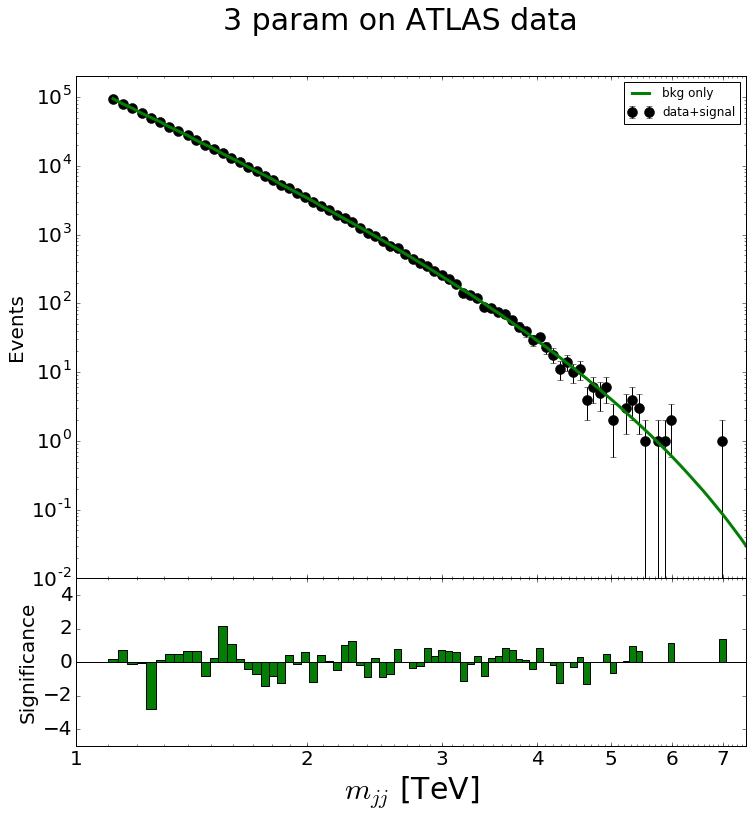

In [14]:
makePrettyPlots(xvalO, yvalO, bkg3param, "3 param on ATLAS data") 

#### run emcee to sample posterior, create covariance matrix

In [15]:
p=best_fit_params
samples = fit_3ff_emcee(p, logLike_3ff_emcee, yvalO)

pvalues = samples.flatchain
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01642826  8.42103327 -5.22731236]


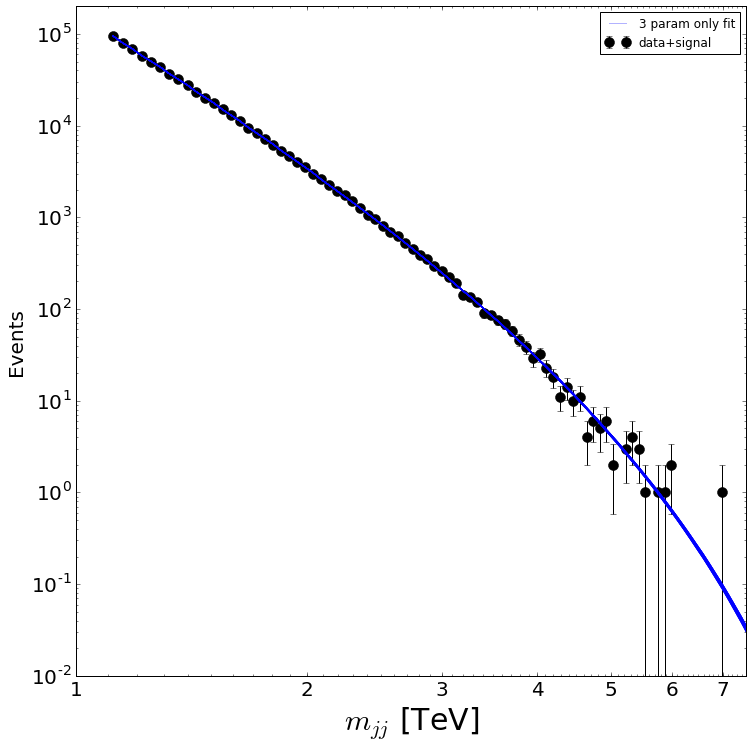

In [16]:
makePrettyPlots_bkgFits(xvalO, yvalO, (modelMatrix[:100]).tolist(), "", ymax = 2e5)

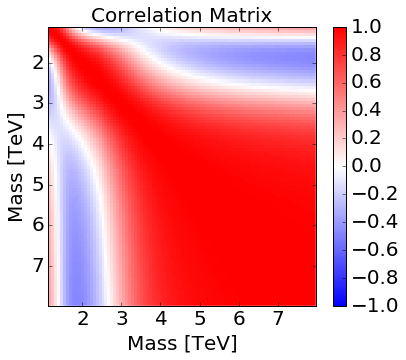

In [44]:
#plot_cov(xvalO2D, corMat, covMat, False)
plot_cor(xvalO2D, corMat, False)

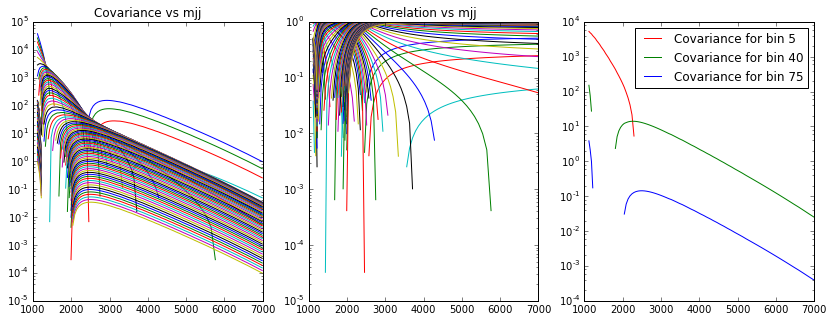

In [26]:
plot_individualCov(corMat, covMat)